# Adding in Volatility using stochastic heston model 

In [9]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec


from BSE import market_session

In [10]:
def heston_simulation(S0, v0, mu, kappa, theta, xi, rho, T, N, paths):
    """
    Simulates price paths using the Heston model.

    Parameters:
    - S0: Initial asset price.
    - v0: Initial variance.
    - mu: Drift (expected return).
    - kappa: Rate of mean reversion for variance.
    - theta: Long-term variance mean.
    - xi: Volatility of variance (vol of vol).
    - rho: Correlation between price and variance.
    - T: Time to maturity.
    - N: Number of time steps.
    - paths: Number of simulation paths.

    Returns:
    - S: Simulated price paths (array of shape (paths, N+1)).
    - v: Simulated variance paths (array of shape (paths, N+1)).
    """
    dt = T / N  # Time step
    S = np.zeros((paths, N + 1))  # Price paths
    v = np.zeros((paths, N + 1))  # Variance paths

    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N + 1):
        # Generate two correlated random normal variables
        z1 = np.random.normal(size=paths)
        z2 = np.random.normal(size=paths)
        W1 = z1
        W2 = rho * z1 + np.sqrt(1 - rho**2) * z2

        # Variance process (CIR)
        v[:, t] = np.maximum(
            v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt + xi * np.sqrt(v[:, t - 1]) * np.sqrt(dt) * W2,
            0  # Ensure variance remains non-negative
        )

        # Price process
        S[:, t] = S[:, t - 1] * np.exp(
            (mu - 0.5 * v[:, t - 1]) * dt + np.sqrt(v[:, t - 1]) * np.sqrt(dt) * W1
        )
    
    return S, v


In [11]:
start_time = 0
end_time = 60 * 3
order_interval = 5

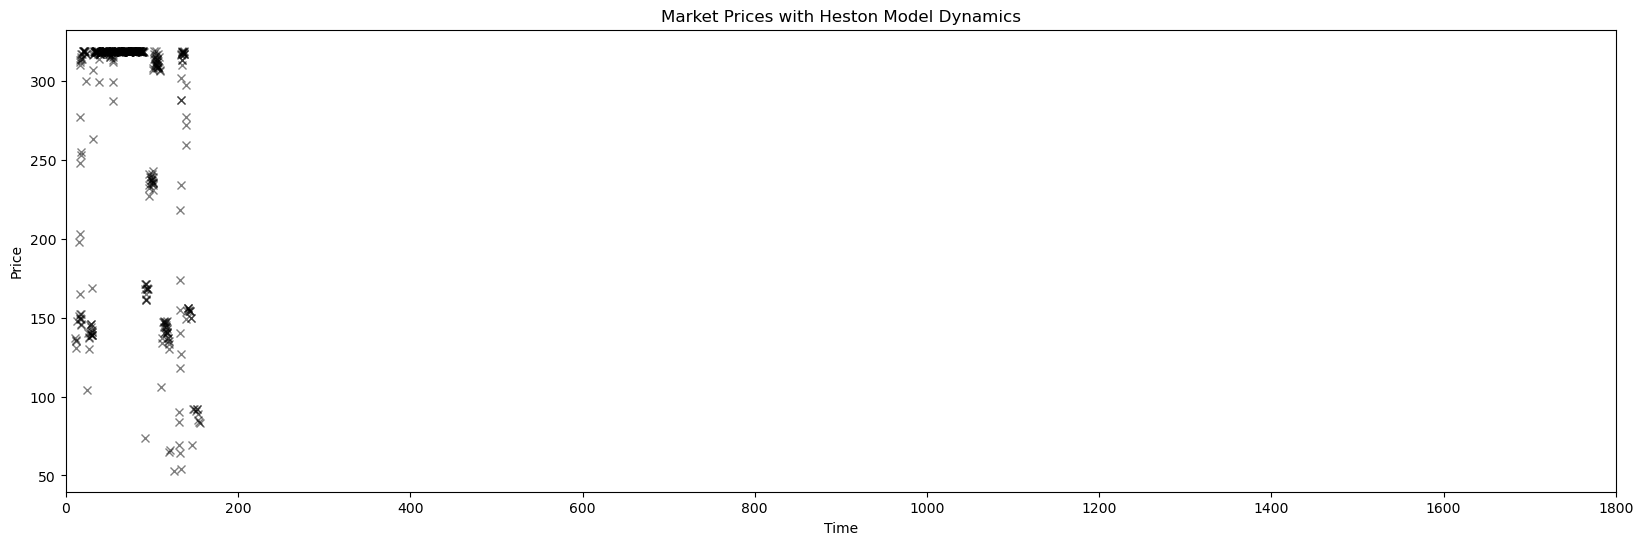

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import csv


start_time = 0
end_time = 60 * 30
order_interval = 5

def heston_simulation(S0, v0, mu, kappa, theta, xi, rho, T, N, paths):
    """
    Simulates price paths using the Heston model.

    Parameters:
    - S0: Initial asset price.
    - v0: Initial variance.
    - mu: Drift (expected return).
    - kappa: Rate of mean reversion for variance.
    - theta: Long-term variance mean.
    - xi: Volatility of variance (vol of vol).
    - rho: Correlation between price and variance.
    - T: Time to maturity.
    - N: Number of time steps.
    - paths: Number of simulation paths.

    Returns:
    - S: Simulated price paths (array of shape (paths, N+1)).
    - v: Simulated variance paths (array of shape (paths, N+1)).
    """
    dt = T / N  # Time step
    S = np.zeros((paths, N + 1))  # Price paths
    v = np.zeros((paths, N + 1))  # Variance paths

    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N + 1):
        # Generate two correlated random normal variables
        z1 = np.random.normal(size=paths)
        z2 = np.random.normal(size=paths)
        W1 = z1
        W2 = rho * z1 + np.sqrt(1 - rho**2) * z2

        # Variance process (CIR)
        v[:, t] = np.maximum(
            v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt + xi * np.sqrt(np.maximum(v[:, t - 1], 0)) * np.sqrt(dt) * W2,
            0  # Ensure variance remains non-negative
        )

        # Price process
        S[:, t] = S[:, t - 1] * np.exp(
            (mu - 0.5 * v[:, t - 1]) * dt + np.sqrt(np.maximum(v[:, t - 1], 0)) * np.sqrt(dt) * W1
        )
    
    return S, v


def create_heston_schedule(S0, v0, mu, kappa, theta, xi, rho, start_time, end_time, N):
    """
    Generates a supply/demand schedule using the Heston Model for stochastic price ranges.

    Parameters:
    - S0: Initial price.
    - v0: Initial variance.
    - mu, kappa, theta, xi, rho: Heston model parameters.
    - start_time, end_time: Time range for the schedule.
    - N: Number of time intervals.

    Returns:
    - A schedule dictionary.
    """
    T = (end_time - start_time)  # Total time horizon
    paths = 1  # Single price path for schedules

    # Simulate Heston price paths
    prices, variances = heston_simulation(S0, v0, mu, kappa, theta, xi, rho, T, N, paths)

    schedule = []
    current_time = start_time
    time_step = T / N

    for i in range(N):
        next_time = current_time + time_step
        price_min = max(bse_sys_minprice, min(bse_sys_maxprice, prices[0, i] - 10))  # Adjust range width as needed
        price_max = max(price_min, min(bse_sys_maxprice, prices[0, i] + 10))  # Ensure max >= min
        schedule.append({'from': current_time, 'to': next_time, 'ranges': [(price_min, price_max)], 'stepmode': 'random'})
        current_time = next_time

    return schedule

# Heston Model Parameters
S0 = 150         # Initial price for supply
v0 = 0.05         # Initial variance
mu = 0.1         # Drift (expected return)
kappa = 3     # Rate of mean reversion
theta = 0.05      # Long-term variance mean
xi = 0.2          # Volatility of variance (vol of vol)
rho = -0.1        # Correlation between price and variance
N = 500
bse_sys_minprice, bse_sys_maxprice = 50, 320

# Create Heston-based schedules
supply_schedule = create_heston_schedule(S0, v0, mu, kappa, theta, xi, rho, start_time, end_time, N)
demand_schedule = create_heston_schedule(S0 - 50, v0, mu, kappa, theta, xi, rho, start_time, end_time, N)

# Update order schedule
order_schedule = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': 'drip-poisson'
}

sellers_spec = [('ZIC', 20)]
buyers_spec = [ ('ZIP', 20), ('ZIP', 20)]
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

verbose = False
dump_flags = {
    'dump_blotters': True,
    'dump_lobs': True,
    'dump_strats': True,
    'dump_avgbals': True,
    'dump_tape': True
}

n_sessions = 1
x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = f"heston_model_session_{sess}"

    # Run the market session
    market_session(trial_id, start_time, end_time, traders_spec, order_schedule, dump_flags, verbose)

    # Read prices from the generated tape
    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x, time)
            y = np.append(y, price)

# Plot the price evolution
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'x', color='black', alpha=0.5)
plt.title("Market Prices with Heston Model Dynamics")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xlim(0, end_time)
plt.show()


In [7]:
sellers_spec = [ ('ZIP', 10)]
#sellers_spec = [ ('ZIC', 20)]
buyers_spec = [('ZIC', 10)]
#buyers_spec = [('ZIP', 20)]

traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

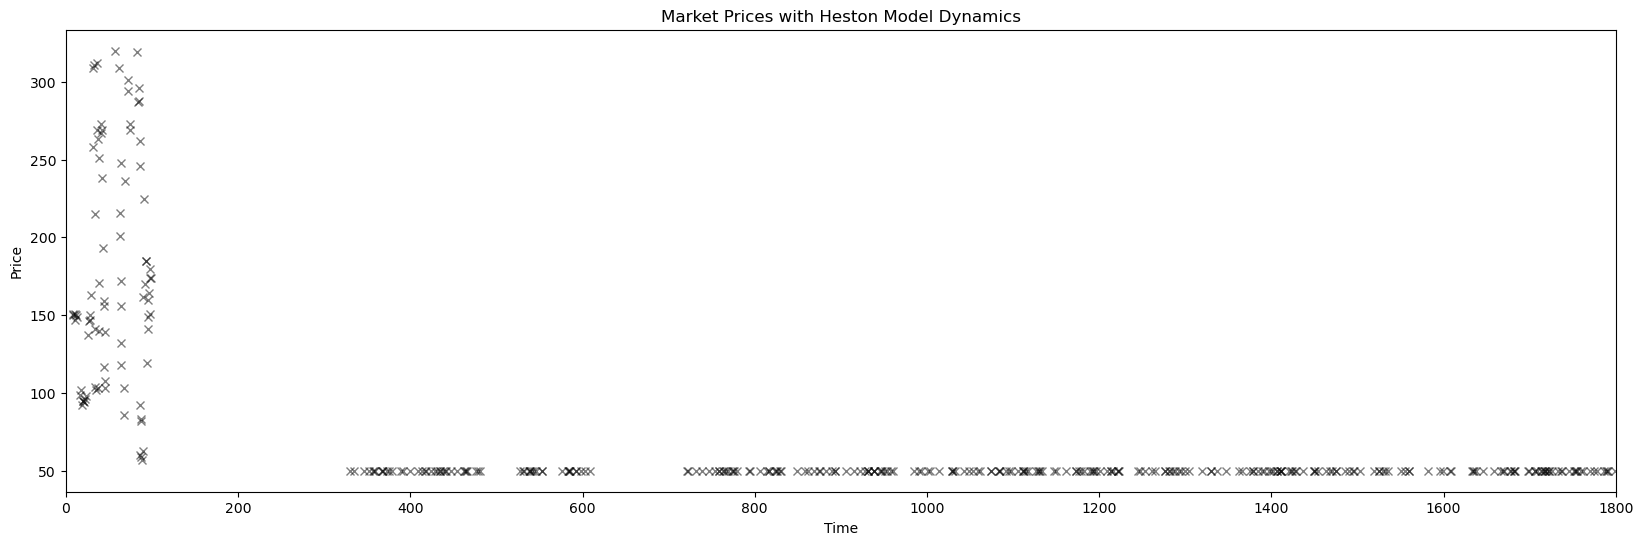

In [8]:
verbose = False
dump_flags = {
    'dump_blotters': True,
    'dump_lobs': True,
    'dump_strats': True,
    'dump_avgbals': True,
    'dump_tape': True
}

n_sessions = 1
x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = f"heston_model_session_{sess}"

    # Run the market session
    market_session(trial_id, start_time, end_time, traders_spec, order_schedule, dump_flags, verbose)

    # Read prices from the generated tape
    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x, time)
            y = np.append(y, price)

# Plot the price evolution
plt.figure(figsize=(20, 6))
plt.plot(x, y, 'x', color='black', alpha=0.5)
plt.title("Market Prices with Heston Model Dynamics")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xlim(0,end_time)
plt.show()
